# Finding Pension Spikers Through Data Science

In [81]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
# Read pension data from SJ Fed City Employees Retirement System, drop the empty columns, and filter by employees
# who retired in 2015

df = pd.read_csv('san-jose-federated-city-employees-retirement-syste-2015.csv')

df = df.drop(["job_title","employer","benefits_amount","notes"], axis=1)
ret_1 = df[df["year_of_retirement"]==2015]

df = pd.read_csv('san-jose-police-and-fire-retirement-plan-2015.csv')
df = df.drop(["job_title","employer","benefits_amount","notes"], axis=1)
ret_2 = df[df["year_of_retirement"]==2015]

In [83]:
#combine the 2 dataframes from the 2 retirement systems and rename the columns

frames = [ret_1,ret_2]
retirees = pd.concat(frames)
retirees.columns = ["retiree_name","pension_15","disability_15","total_pension_15","years_of_service","year_of_retirement","year","pension_system"]

In [84]:
# filter out pension beneficiaries and those receive disability pensions

retirees = retirees[retirees["years_of_service"]!="Beneficiary"]
retirees = retirees[retirees["disability_15"] == 0.]

In [85]:
# change years of service from object to float

years_of_service = retirees["years_of_service"]
yos_float= []
for duration in years_of_service:
    duration = float(duration)
    yos_float.append(duration)
retirees["years_of_service"] = yos_float

In [86]:
retirees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 7 to 2078
Data columns (total 8 columns):
retiree_name          150 non-null object
pension_15            150 non-null float64
disability_15         150 non-null float64
total_pension_15      150 non-null float64
years_of_service      150 non-null float64
year_of_retirement    150 non-null int64
year                  150 non-null int64
pension_system        150 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 10.5+ KB


In [87]:
retirees.describe()

,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year
count,150.000000,150.0,150.000000,150.000000,150.0,150.0
mean,57504.728800,0.0,57504.728800,21.238933,2015.0,2015.0
std,33067.983428,0.0,33067.983428,7.127869,0.0,0.0
min,6870.720000,0.0,6870.720000,1.630000,2015.0,2015.0
25%,34304.370000,0.0,34304.370000,16.225000,2015.0,2015.0
50%,52359.060000,0.0,52359.060000,24.080000,2015.0,2015.0
75%,76658.430000,0.0,76658.430000,26.115000,2015.0,2015.0
max,179610.600000,0.0,179610.600000,30.160000,2015.0,2015.0


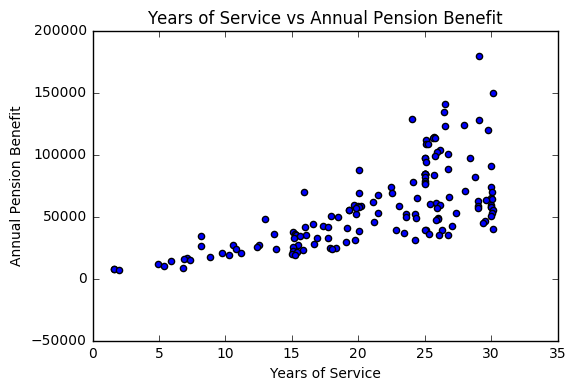

In [88]:
x = retirees["years_of_service"]
y = retirees["pension_15"]

plt.scatter(x, y,)
plt.title("Years of Service vs Annual Pension Benefit")
plt.xlabel("Years of Service")
plt.ylabel("Annual Pension Benefit")
plt.show()

In [89]:
# Find duplicate names among those who retired in 2015 - there are three
#retirees["retiree_name"].value_counts()

retiree_dups = ["Gilbert Hernandez","David Arroyo", "Ann Danforth"]
retirees.loc[retirees['retiree_name'].isin(retiree_dups)]

,retiree_name,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
622,David Arroyo,69688.92,0.0,69688.92,30.06,2015,2015,San Jose Federated City Employees' Retirement ...
796,David Arroyo,64030.20,0.0,64030.20,30.06,2015,2015,San Jose Federated City Employees' Retirement ...
992,Gilbert Hernandez,58568.40,0.0,58568.40,29.01,2015,2015,San Jose Federated City Employees' Retirement ...
1074,Gilbert Hernandez,56921.64,0.0,56921.64,29.01,2015,2015,San Jose Federated City Employees' Retirement ...
3816,Ann Danforth,7610.04,0.0,7610.04,1.63,2015,2015,San Jose Federated City Employees' Retirement ...
3817,Ann Danforth,7610.04,0.0,7610.04,1.63,2015,2015,San Jose Federated City Employees' Retirement ...


In [90]:
# It's not clear why these retirees have duplicate records. Will retain the record with the higher pension payment,
# and delete the other one. 
retirees.drop([796,1074,3817], inplace=True)

In [91]:
retirees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 7 to 2078
Data columns (total 8 columns):
retiree_name          147 non-null object
pension_15            147 non-null float64
disability_15         147 non-null float64
total_pension_15      147 non-null float64
years_of_service      147 non-null float64
year_of_retirement    147 non-null int64
year                  147 non-null int64
pension_system        147 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 10.3+ KB


In [126]:
# Read the salary files and find the duplicate names in the payroll files

def find_double_names(df, name_field):
    employee_name_counts = df[name_field].value_counts()
    double_names = []
    for name in employee_name_counts.index:
        if employee_name_counts.loc[name] > 1:
            double_names.append(name)
    return double_names

df_13 = pd.read_csv('City Comp 2013.csv')
df_14 = pd.read_csv('City Comp 2014.csv')
df_15 = pd.read_csv('City Comp 2015.csv')


double_name_list = list(set(find_double_names(df_13, "NAME") + find_double_names(df_14, "Name") + find_double_names(df_15, "Name")))
double_name_list.sort()

In [127]:
def find_name_parts(df, name_field):
    df["name_parts"] = df[name_field].map(lambda x: x.replace(",", " "))
    df["name_parts"] = df["name_parts"].map(lambda x: x.split())
    df["name_parts"].astype(str)
    return None

find_name_parts(df_15, "Name")
find_name_parts(df_14, "Name")
find_name_parts(df_13, "NAME")

In [128]:
df_15["name_word_count"] = df_15["name_parts"].map(lambda x: len(x))

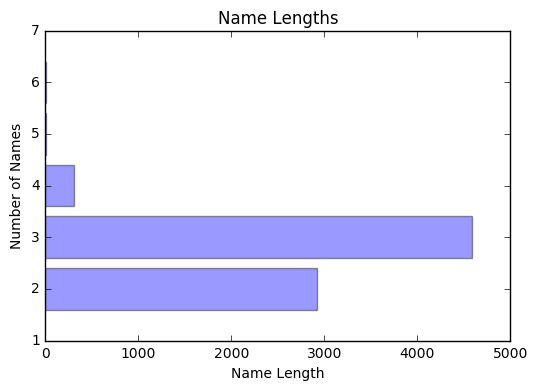

In [129]:
name_length_counts = df_15.groupby(["name_word_count"])[["name_word_count"]].count()

x = name_length_counts.index
y = name_length_counts.values

plt.barh(x, y,align='center', alpha=0.4)
plt.title("Name Lengths")
plt.xlabel("Name Length")
plt.ylabel("Number of Names")
plt.show()

In [130]:
def remove_name_suffixes(df):
    i = ["Jr", "II", "III", "Sr", "Jr."]
    name_parts_cleaned = []
    for l in df["name_parts"]:
        for w in l:
            if w in i:
                l.remove(w)
        name_parts_cleaned.append(l)
    df["name_parts"] = name_parts_cleaned
    return None

remove_name_suffixes(df_15)
remove_name_suffixes(df_14)
remove_name_suffixes(df_13)

In [131]:
def make_firstlast_name(df, name_parts_field):
    first_last = []
    for item in df[name_parts_field]:
        if len(item) == 2:
            first_last.append(item[1]+' '+item[0])
        if len(item) == 3:
            first_last.append(item[1]+' '+item[0])
        if len(item) == 4:
            first_last.append(item[2]+' '+item[0]+' '+item[1])
        if len(item) == 5:
            first_last.append(item[3]+' '+item[0]+' '+item[1]+' '+item[2])
        if len(item) == 6:
            first_last.append(item[3]+' '+item[0]+' '+item[1]+' '+item[2])
    df["retiree_name"] = first_last
    return None
    
make_firstlast_name(df_13 ,"name_parts")
make_firstlast_name(df_14 ,"name_parts")
make_firstlast_name(df_15 ,"name_parts")


In [132]:
df_13

,NAME,Department Name,Job Title,Total Cash Compensation,Base Pay,Overtime,Sick and Vacation Payouts,Other Cash Compensation,Deferred Comp Paid by Employer,Medical Dental Vision City Paid,Employer's Share Pension Payments,Retired?,name_parts,retiree_name
0,"Bustillos,Steven D",Police,Police Sergeant,286137.69,90888.00,89867.88,97969.79,7412.02,NaN,13640.50,74429.71,Yes,"[Bustillos, Steven, D]",Steven Bustillos
1,"Figone,Debra J",City Manager,City Manager U,248564.84,227975.02,NaN,NaN,20589.82,20517.64,15166.00,131032.44,Yes,"[Figone, Debra, J]",Debra Figone
2,"Guerra,Daniel P",Police,Police Officer,241039.12,97198.40,132104.54,NaN,11736.18,NaN,15371.56,79821.51,No,"[Guerra, Daniel, P]",Daniel Guerra
3,"Moore,Christopher M",Police,Chief Of Police U,233540.32,15319.54,NaN,215470.80,2749.98,NaN,1371.81,11204.16,Yes,"[Moore, Christopher, M]",Christopher Moore
4,"Vasquez,Hector M",Police,Police Officer,230469.85,97198.40,124552.69,NaN,8718.76,NaN,16345.32,79821.51,No,"[Vasquez, Hector, M]",Hector Vasquez
5,"Lee,Ivan D",Fire,Battalion Chief,230281.85,141835.20,73577.15,NaN,14869.50,NaN,16345.32,106663.67,No,"[Lee, Ivan, D]",Ivan Lee
6,"Doyle,John Richard",Attorney,City Attorney U,226311.93,206116.04,NaN,NaN,20195.89,14428.05,1311.84,118450.54,No,"[Doyle, John, Richard]",John Doyle
7,"Tran,Ken H",Police,Police Officer,219320.66,97198.40,113403.50,NaN,8718.76,NaN,16345.32,79821.51,No,"[Tran, Ken, H]",Ken Tran
8,"Esquivel Jr,Larry B",Police,Chief Of Police U,218284.29,192910.68,NaN,NaN,25373.61,NaN,16345.32,167012.65,No,"[Esquivel, Larry, B]",Larry Esquivel
9,"Shikada,Edward K",City Manager,City Manager U,214331.96,205827.95,NaN,NaN,8504.01,NaN,16139.76,120288.95,No,"[Shikada, Edward, K]",Edward Shikada


In [157]:
double_name_list

24

In [156]:
# Need to see if any of the duplicate employee names (working from 2013 to 2015) match any 2015 retirees.
# pulll out the names in first last format, and then creat a set to eliminate duplicates

def find_dup_employees_names(df, name_field):
    double_name_fl = []
    for index, row in df.iterrows():
        for name in double_name_list:
            if name == row[name_field]:
                double_name_fl.append(row['retiree_name'])
    return double_name_fl

dup_employee_names = find_dup_employees_names(df_15, "Name") + find_dup_employees_names(df_14, "Name") + find_dup_employees_names(df_13, "NAME")
myset = set(dup_employee_names)

24

In [160]:
# Need to compare the names in myset with the retiree names in retirees

matches = []
for emp_name in myset:
    for ret_name in retirees['retiree_name']:
        if emp_name == ret_name:
            matches.append(emp_name)
matches

['James Wilson']

In [161]:
retirees[retirees["retiree_name"] == "James Wilson"]

# there were 2 people names James A Wilson working up to 2015 - an Assoc Engineer and a Mechanic,
# both from the Public Works departments. I deduced that the Mechanic is the retiree (payouts in 2015
# vastly different 2015 vs 2014 base pay). Delete the unneeded row (the Assoc Engineer).

,retiree_name,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
1255,James Wilson,53153.4,0.0,53153.4,30.05,2015,2015,San Jose Federated City Employees' Retirement ...


In [165]:
df_15[df_15["retiree_name"] == "James Wilson"]

,Name,Department,Job Title (as of 12/31/15),Total Cash Compensation,Base Pay,Overtime,Sick and Vacation Payouts,Other Cash Compensation,Defined Contribution Plan Contributions - City Paid,Medical Dental Vision,Retirement Contributions - City Paid*,"Long Term Disability, Life, Medicare",Misc Employment Related Costs,name_parts,name_word_count,retiree_name
2565,"Wilson,James A",Public Works,Assoc Engineer,92351.32,90460.80,NaN,NaN,1890.52,NaN,12807.12,64442.83,1681.24,NaN,"[Wilson, James, A]",3,James Wilson
3279,"Wilson,James A",Public Works,Temp Employee Retiree U,77817.78,33991.16,3144.42,40548.0,134.20,NaN,1056.22,3705.68,1130.22,NaN,"[Wilson, James, A]",3,James Wilson


In [166]:
df_14[df_14["retiree_name"] == "James Wilson"]

,Name,Department Name,Job Title (as of 12/31/14),Total Cash Compensation,Base Pay,Overtime,Sick and Vacation Payouts,Other Cash Compensation,Deferred Comp Paid by Employer,Medical Dental Vision City Paid,Employer's Share Pension Payments,"Long Term Disability, Life, Medicare",Misc Employment Related Costs,name_parts,retiree_name
1935,"Wilson,James A",Public Works,Mechanic,104020.50,69222.4,31185.51,NaN,3612.59,NaN,12998.04,44656.86,1519.09,NaN,"[Wilson, James, A]",James Wilson
2554,"Wilson,James A",Public Works,Assoc Engineer,88691.49,87818.4,NaN,NaN,873.09,NaN,13130.52,56625.05,1534.21,NaN,"[Wilson, James, A]",James Wilson


In [167]:
df_13[df_13["retiree_name"] == "James Wilson"]

,NAME,Department Name,Job Title,Total Cash Compensation,Base Pay,Overtime,Sick and Vacation Payouts,Other Cash Compensation,Deferred Comp Paid by Employer,Medical Dental Vision City Paid,Employer's Share Pension Payments,Retired?,name_parts,retiree_name
2302,"Wilson,James A",General Services,Mechanic,90588.46,67308.8,21339.64,NaN,1940.02,NaN,16139.76,38686.84,No,"[Wilson, James, A]",James Wilson
2618,"Wilson,James A",Public Works,Assoc Engineer,83227.90,81917.6,NaN,NaN,1310.30,NaN,16139.76,47423.05,No,"[Wilson, James, A]",James Wilson


In [171]:
df_13.drop([2618], inplace=True)
df_13[df_13["retiree_name"] == "James Wilson"]

,NAME,Department Name,Job Title,Total Cash Compensation,Base Pay,Overtime,Sick and Vacation Payouts,Other Cash Compensation,Deferred Comp Paid by Employer,Medical Dental Vision City Paid,Employer's Share Pension Payments,Retired?,name_parts,retiree_name
2302,"Wilson,James A",General Services,Mechanic,90588.46,67308.8,21339.64,NaN,1940.02,NaN,16139.76,38686.84,No,"[Wilson, James, A]",James Wilson


In [175]:
df_13.shape

(7371, 14)

In [ ]:
# now that we have manually deleted the James Wilson row that we don't need, we need to remove James A Wilson from
# the duplicate names list. So we don't delete the James A Wilson data we do need.
# Need to research deleting by entry

del double_name_list[-2]


In [178]:
# remove 

df_13 = df_13[~df_13["NAME"].isin(double_name_list)]
df_14 = df_14[~df_14["Name"].isin(double_name_list)]
df_15 = df_15[~df_15["Name"].isin(double_name_list)]

In [183]:


def change_col_names(df,year):
    new_cols = []
    for col in df.columns:
        new_cols.append(col+year)
    df.columns = new_cols
    return None
    
#change_col_names(df_15, "-2015")
change_col_names(df_14, "-2014")
change_col_names(df_13, "-2013")

In [185]:
df_13

,NAME-2013,Department Name-2013,Job Title-2013,Total Cash Compensation-2013,Base Pay-2013,Overtime-2013,Sick and Vacation Payouts-2013,Other Cash Compensation-2013,Deferred Comp Paid by Employer-2013,Medical Dental Vision City Paid-2013,Employer's Share Pension Payments-2013,Retired?-2013,name_parts-2013,retiree_name-2013
0,"Bustillos,Steven D",Police,Police Sergeant,286137.69,90888.00,89867.88,97969.79,7412.02,NaN,13640.50,74429.71,Yes,"[Bustillos, Steven, D]",Steven Bustillos
1,"Figone,Debra J",City Manager,City Manager U,248564.84,227975.02,NaN,NaN,20589.82,20517.64,15166.00,131032.44,Yes,"[Figone, Debra, J]",Debra Figone
2,"Guerra,Daniel P",Police,Police Officer,241039.12,97198.40,132104.54,NaN,11736.18,NaN,15371.56,79821.51,No,"[Guerra, Daniel, P]",Daniel Guerra
3,"Moore,Christopher M",Police,Chief Of Police U,233540.32,15319.54,NaN,215470.80,2749.98,NaN,1371.81,11204.16,Yes,"[Moore, Christopher, M]",Christopher Moore
4,"Vasquez,Hector M",Police,Police Officer,230469.85,97198.40,124552.69,NaN,8718.76,NaN,16345.32,79821.51,No,"[Vasquez, Hector, M]",Hector Vasquez
5,"Lee,Ivan D",Fire,Battalion Chief,230281.85,141835.20,73577.15,NaN,14869.50,NaN,16345.32,106663.67,No,"[Lee, Ivan, D]",Ivan Lee
6,"Doyle,John Richard",Attorney,City Attorney U,226311.93,206116.04,NaN,NaN,20195.89,14428.05,1311.84,118450.54,No,"[Doyle, John, Richard]",John Doyle
7,"Tran,Ken H",Police,Police Officer,219320.66,97198.40,113403.50,NaN,8718.76,NaN,16345.32,79821.51,No,"[Tran, Ken, H]",Ken Tran
8,"Esquivel Jr,Larry B",Police,Chief Of Police U,218284.29,192910.68,NaN,NaN,25373.61,NaN,16345.32,167012.65,No,"[Esquivel, Larry, B]",Larry Esquivel
9,"Shikada,Edward K",City Manager,City Manager U,214331.96,205827.95,NaN,NaN,8504.01,NaN,16139.76,120288.95,No,"[Shikada, Edward, K]",Edward Shikada


In [186]:
# Rename the employee's name column, which is the field to join the 3 tables

df_15.rename(columns={'Name-2015':'Name'}, inplace=True)
df_14.rename(columns={'Name-2014':'Name'}, inplace=True)
df_13.rename(columns={'NAME-2013':'Name'}, inplace=True)


In [187]:
u = df_15.merge(df_14, on=['Name'], how='inner')

In [188]:
u.shape

(6512, 30)

In [189]:
v = u.merge(df_13, on=['Name'], how='inner')

In [190]:
v.shape

(5670, 43)

In [191]:
v.rename(columns={'retiree_name-2015':'retiree_name'}, inplace=True)

In [192]:
data = v.merge(retirees, on=['retiree_name'], how='inner')

In [211]:
data["retiree_name"].value_counts()

James Voreyer            1
Leslye Corsiglia         1
David Arroyo             1
Maria Jimenez            1
Leticia Rosales          1
Lynn Harris              1
Mark Smyth               1
Marjorie Beiderman       1
Juan Amarilla            1
Michael Okubo            1
Tami Mason               1
Karen Schlussel          1
George Marcussen         1
Ralph Padilla            1
Kenneth Johnson          1
John Navarra             1
Dale Harris              1
Terri Gomes              1
William Chan             1
Kevin Metcalf            1
Reymartin Cedeno         1
Kenneth Leytem           1
Steven Barnett           1
Stanley White            1
Gilbert Hernandez        1
Richard Bailey           1
Brenda Nakasaki          1
Michael Sullivan         1
Colleen Cassidy          1
Loralyn Tanase           1
                        ..
Louis Dominguez          1
Robert Dale              1
Steven Gibson            1
Pamela Burton            1
Henry Lacaze             1
Rosemarie Leon-Monday    1
C

In [205]:
search_term = "James Williams"
data[data["retiree_name"]==search_term]

,Name,Department-2015,Job Title (as of 12/31/15)-2015,Total Cash Compensation-2015,Base Pay-2015,Overtime-2015,Sick and Vacation Payouts-2015,Other Cash Compensation-2015,Defined Contribution Plan Contributions - City Paid-2015,Medical Dental Vision-2015,...,Retired?-2013,name_parts-2013,retiree_name-2013,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
50,"Williams,James M",Transportation,Maintenance Worker II,66713.43,58541.6,6356.79,NaN,1815.04,NaN,12674.64,...,No,"[Williams, James, M]",James Williams,69204.0,0.0,69204.0,20.05,2015,2015,San Jose Police and Fire Retirement Plan
51,"Williams Jr,James",Fire,Fire Fighter,25364.78,10202.4,68.32,13843.39,1250.67,NaN,1995.97,...,No,"[Williams, James]",James Williams,69204.0,0.0,69204.0,20.05,2015,2015,San Jose Police and Fire Retirement Plan


In [210]:
# Need to remove some rows that were mismatched, based on similar names
# Torres 7 (not a Fire), 8 (salary too low for pension benefit)
# Johnson 38 (other Johnson has payouts)
# Sullivan 3 (other Sullivan has massive payouts)
# Williams 50 (he's not a FF, though it's a FF pension)

data.pension_system.value_counts()

#data.drop([3,7,8,38,50], inplace=True)

#data

San Jose Federated City Employees' Retirement System    78
San Jose Police and Fire Retirement Plan                44
Name: pension_system, dtype: int64

In [216]:

data[['Name', 'Department-2015', u'Job Title (as of 12/31/15)-2015',
       'Total Cash Compensation-2015', 'Base Pay-2015', 'Overtime-2015',
       'Sick and Vacation Payouts-2015', 'Other Cash Compensation-2015']]

,Name,Department-2015,Job Title (as of 12/31/15)-2015,Total Cash Compensation-2015,Base Pay-2015,Overtime-2015,Sick and Vacation Payouts-2015,Other Cash Compensation-2015
0,"Unland,James C",Police,Police Sergeant,215941.52,13951.20,29370.18,171489.44,1130.70
1,"Larsen,Hans F",Transportation,Dir of Transportation U,200264.53,80932.21,NaN,117582.32,1750.00
2,"Albin,Gregory R",Police,Police Lieutenant,196676.89,10772.80,35827.98,148189.69,1886.42
4,"Sullivan,Michael J",Police,Police Officer,162154.99,12052.80,21513.62,127600.25,988.32
5,"Kuchac,Timothy R",Police,Police Lieutenant,190218.89,16159.20,37782.23,134981.16,1296.30
6,"Torres,Ruben L",Fire,Fire Chief U,190193.03,24142.05,NaN,164279.68,1771.30
9,"Olmos,Albert N",Fire,Fire Division Chief,170088.79,12433.68,NaN,156198.93,1456.18
10,"Pham,Uyen T",Police,Police Officer,158613.16,12052.80,17829.04,126930.63,1800.69
11,"Foster,Terry L",Police,Police Officer,154280.33,43691.40,17686.00,89344.87,3558.06
12,"Newton,William A",Fire,Fire Captain,147130.57,52291.20,5834.47,83147.68,5857.22


In [223]:
not_matched = retirees[~retirees["retiree_name"].isin(data["retiree_name"])]

In [227]:
not_matched.columns

Index([u'retiree_name', u'pension_15', u'disability_15', u'total_pension_15',
       u'years_of_service', u'year_of_retirement', u'year', u'pension_system'],
      dtype='object')

In [233]:
worked_in_2015 = []
for name in df_15["retiree_name-2015"]:
    for nom in not_matched["retiree_name"]:
        if name == nom:
            worked_in_2015.append(nom)
worked_in_2015          

['John Spicer',
 'James Wilson',
 'Sharon Caudill',
 'Nelson Joslin',
 'Dominic Cavallaro',
 'Joseph Alvarado',
 'Martin Noguez',
 'Dana Singh',
 'Theresa Morreira-Warn',
 'Dwayne Taylor',
 'Susan Amaro']

In [238]:
df_15[df_15["retiree_name-2015"].isin(worked_in_2015)].head()

,Name,Department-2015,Job Title (as of 12/31/15)-2015,Total Cash Compensation-2015,Base Pay-2015,Overtime-2015,Sick and Vacation Payouts-2015,Other Cash Compensation-2015,Defined Contribution Plan Contributions - City Paid-2015,Medical Dental Vision-2015,Retirement Contributions - City Paid*-2015,"Long Term Disability, Life, Medicare-2015",Misc Employment Related Costs-2015,name_parts-2015,name_word_count-2015,retiree_name-2015
1787,"Spicer,John D",Police,Police Lieutenant,116037.20,NaN,NaN,116037.20,NaN,NaN,NaN,NaN,1682.54,NaN,"[Spicer, John, D]",3,John Spicer
3279,"Wilson,James A",Public Works,Temp Employee Retiree U,77817.78,33991.16,3144.42,40548.00,134.20,NaN,1056.22,3705.68,1130.22,NaN,"[Wilson, James, A]",3,James Wilson
3761,"Caudill,Sharon Lee",Planning/Building/Code,Temp Employee Retiree U,68143.58,25498.30,2044.98,40600.30,NaN,NaN,2157.45,14446.11,991.11,17.0,"[Caudill, Sharon, Lee]",3,Sharon Caudill
4997,"Joslin,Nelson E",Fire,Senr Pub Safe Dispatch,35955.00,NaN,NaN,35955.00,NaN,NaN,NaN,NaN,521.35,NaN,"[Joslin, Nelson, E]",3,Nelson Joslin
5050,"Cavallaro Jr.,Dominic Paul",Library,Warehouse Worker II,34242.63,26540.80,6.38,7639.77,55.68,NaN,6400.20,18089.60,451.06,25.5,"[Cavallaro, Dominic, Paul]",4,Dominic Cavallaro


In [234]:
worked_in_2014 = []
for name in df_14["retiree_name-2014"]:
    for nom in not_matched["retiree_name"]:
        if name == nom:
            worked_in_2014.append(nom)
worked_in_2014


['James Wilson', 'Ghebreab Gehal']

In [240]:
df_14[df_14["retiree_name-2014"].isin(worked_in_2014)]

,Name,Department Name-2014,Job Title (as of 12/31/14)-2014,Total Cash Compensation-2014,Base Pay-2014,Overtime-2014,Sick and Vacation Payouts-2014,Other Cash Compensation-2014,Deferred Comp Paid by Employer-2014,Medical Dental Vision City Paid-2014,Employer's Share Pension Payments-2014,"Long Term Disability, Life, Medicare-2014",Misc Employment Related Costs-2014,name_parts-2014,retiree_name-2014
1935,"Wilson,James A",Public Works,Mechanic,104020.50,69222.4,31185.51,NaN,3612.59,NaN,12998.04,44656.86,1519.09,NaN,"[Wilson, James, A]",James Wilson
4786,"Gehal,Ghebreab M",Airport,Network Technician II,41122.37,32542.4,NaN,8544.97,35.00,NaN,8150.50,19714.80,582.26,21.25,"[Gehal, Ghebreab, M]",Ghebreab Gehal


In [235]:
worked_in_2013 = []
for name in df_13["retiree_name-2013"]:
    for nom in not_matched["retiree_name"]:
        if name == nom:
            worked_in_2013.append(nom)
worked_in_2013


['Ghebreab Gehal', 'Nelson Joslin', 'Joseph Alvarado', 'Richard Wicklander']

In [241]:
# have payment information for 122 employees who retired in 2015, plus salaries for their last 3 years of working
data.shape

(122, 50)